1. Подготовка и очистка текстов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import re
import nltk
from tqdm import tqdm
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')  # Загрузка списка стоп-слов
nltk.download('wordnet')    # Загрузка данных для лемматизации

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balyb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
tokenizer = TreebankWordTokenizer()  # Инициализация токенизатора
lemmatizer = WordNetLemmatizer()     # Инициализация лемматизатора
stop_words = set(stopwords.words('english'))  # Загрузка стоп-слов для английского языка

df = pd.read_csv("Reviews.csv", encoding='utf8')  # Чтение файла
df = df.dropna()  # Удаление пустых строк

# Очистка текста
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text) # Удаление HTML-тегов
    text = re.sub(r'[^a-zA-Z\s!?]', '', str(text)) # Удаление всех символов, кроме букв, пробелов, !  и ?
    text = re.sub(r'\s+', ' ', text).strip() # Удаление лишних пробелов
    text = text.lower() # Приведение к нижнему регистру
    tokens = tokenizer.tokenize(text) # Токенизация текста
    tokens = [
    lemmatizer.lemmatize(w) if w.isalpha() else w  # применяем лемматизацию только к словам
    for w in tokens
    if (w not in stop_words and w.isalpha()) or w in ['!', '?']  # сохраняем ! и ?
    ]
    return ' '.join(tokens)  # Объединение токенов обратно в строку

tqdm.pandas()  # Инициализация прогресс-бара
df['CleanText'] = df['Text'].progress_apply(preprocess_text)  # Применение функции с визуализацией прогресса

df.to_csv("Cleaned_Reviews.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████| 568401/568401 [02:18<00:00, 4097.88it/s]


2.	Разведочный анализ текстов (EDA)

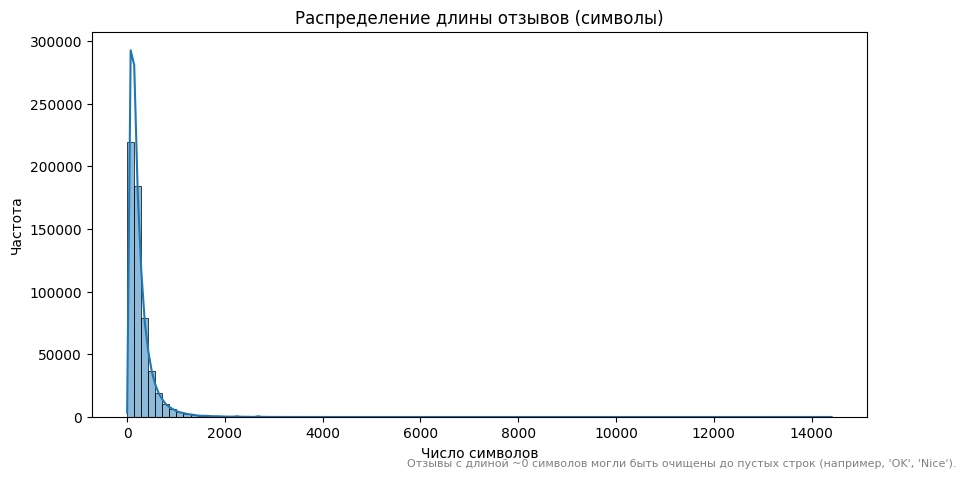

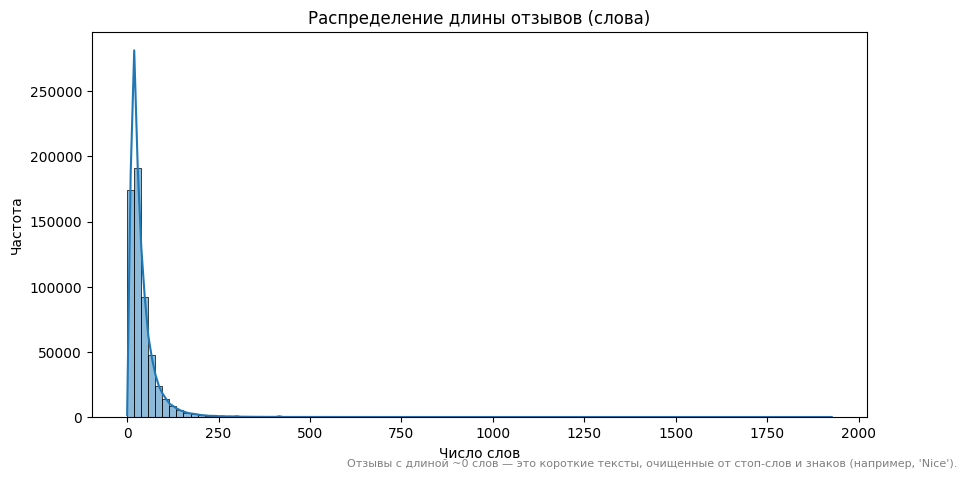

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

df['char_length'] = df['CleanText'].apply(len)
df['word_count'] = df['CleanText'].apply(lambda x: len(x.split()))

# Длина в символах
plt.figure(figsize=(10, 5))
sns.histplot(df['char_length'], bins=100, kde=True)
plt.title("Распределение длины отзывов (символы)")
plt.xlabel("Число символов")
plt.ylabel("Частота")
plt.figtext(0.99, 0.01,
            "Отзывы с длиной ~0 символов могли быть очищены до пустых строк (например, 'OK', 'Nice').",
            horizontalalignment='right', fontsize=8, color='gray')
plt.show()

# Длина в словах
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=100, kde=True)
plt.title("Распределение длины отзывов (слова)")
plt.xlabel("Число слов")
plt.ylabel("Частота")
plt.figtext(0.99, 0.01,
            "Отзывы с длиной ~0 слов — это короткие тексты, очищенные от стоп-слов и знаков (например, 'Nice').",
            horizontalalignment='right', fontsize=8, color='gray')
plt.show()


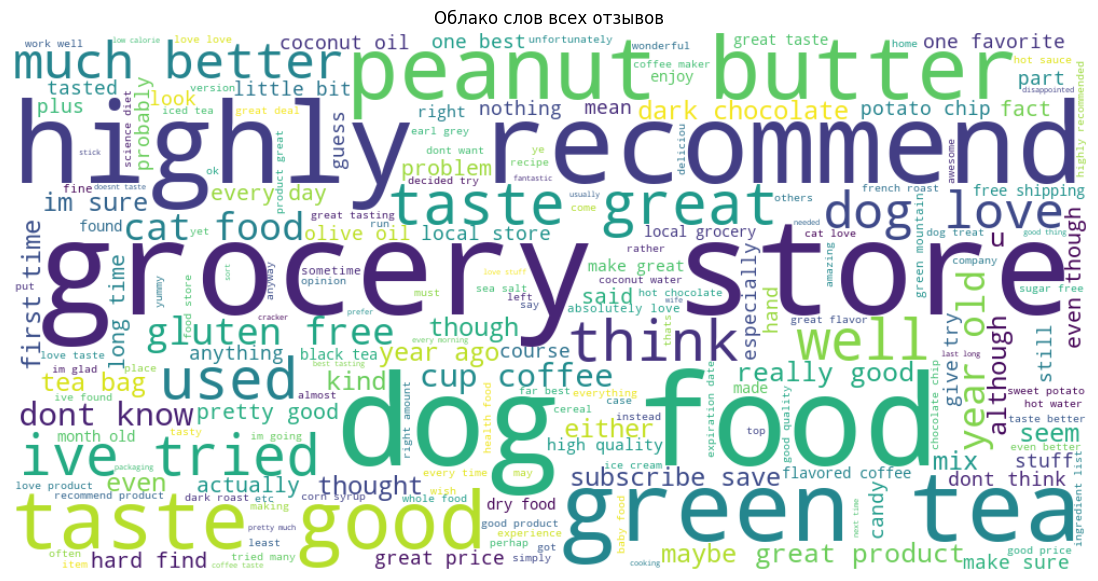

In [6]:
all_words = ' '.join(df['CleanText'])

# Генерация облака слов
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(all_words)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Облако слов всех отзывов")
plt.show()


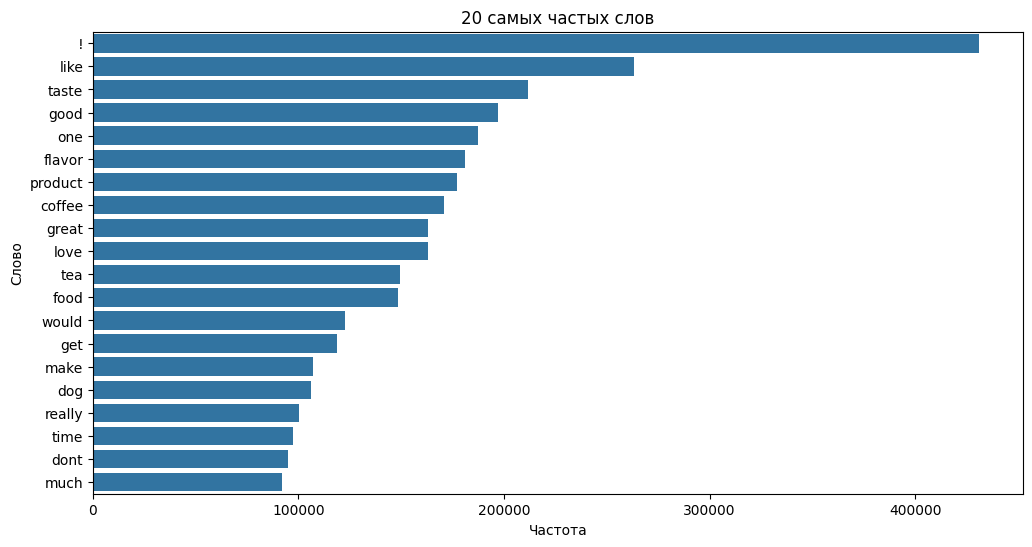

In [7]:
from collections import Counter

word_freq = Counter(all_words.split())
most_common = word_freq.most_common(20)

words, counts = zip(*most_common)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words))
plt.title("20 самых частых слов")
plt.xlabel("Частота")
plt.ylabel("Слово")
plt.show()


/tmp/ipython-input-15-2891880164.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rating_lengths, x='Score', y='word_count', palette='viridis')


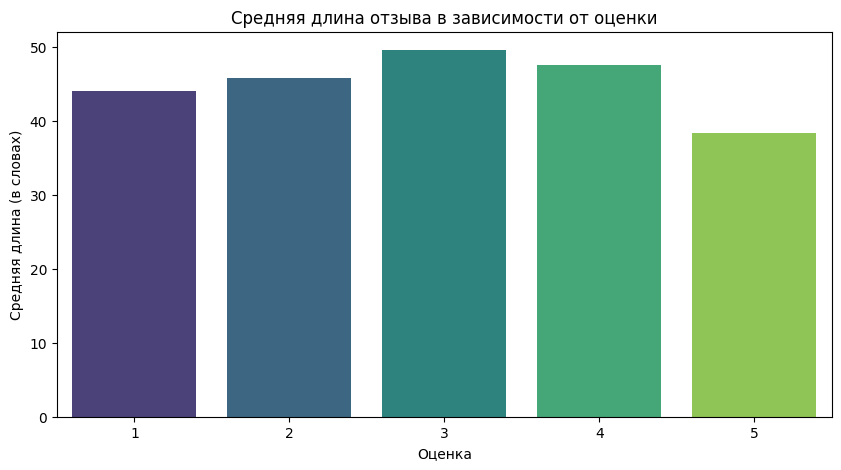

In [ ]:
rating_lengths = df.groupby('Score')['word_count'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=rating_lengths, x='Score', y='word_count', palette='viridis')
plt.title("Средняя длина отзыва в зависимости от оценки")
plt.xlabel("Оценка")
plt.ylabel("Средняя длина (в словах)")
plt.show()


Медианная длина отзыва в словах: 29.0
Медианная длина отзыва в символах: 182.0


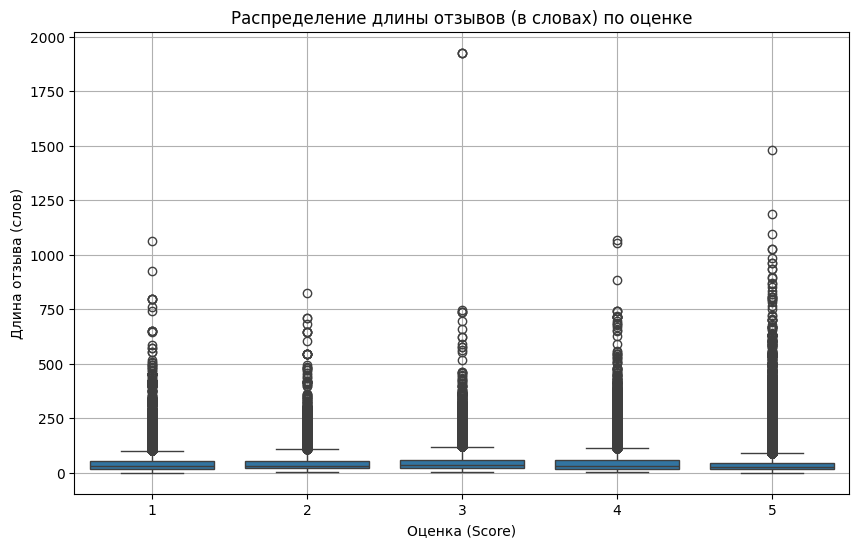


Средняя длина отзывов по оценкам (в словах):
Score
1    44.149759
2    45.015029
3    47.646466
4    45.962717
5    38.160688
Name: ReviewLengthWords, dtype: float64


In [8]:
df['ReviewLengthWords'] = df['CleanText'].apply(lambda x: len(str(x).split()))
df['ReviewLengthChars'] = df['CleanText'].apply(lambda x: len(str(x)))

# Медианные значения
median_words = df['ReviewLengthWords'].median()
median_chars = df['ReviewLengthChars'].median()

print(f"Медианная длина отзыва в словах: {median_words}")
print(f"Медианная длина отзыва в символах: {median_chars}")

# Boxplot: длина отзывов по оценке (в словах)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Score', y='ReviewLengthWords')
plt.title('Распределение длины отзывов (в словах) по оценке')
plt.xlabel('Оценка (Score)')
plt.ylabel('Длина отзыва (слов)')
plt.grid(True)
plt.show()

# Средняя длина по оценкам
mean_lengths = df.groupby('Score')['ReviewLengthWords'].mean()
print("\nСредняя длина отзывов по оценкам (в словах):")
print(mean_lengths)


3.Создание признаков

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF векторизатор
tfidf = TfidfVectorizer(max_features=50)
tfidf_features = tfidf.fit_transform(df['CleanText'])

tfidf_df = pd.DataFrame(
    tfidf_features.toarray(),
    columns=[f"tfidf_{word}" for word in tfidf.get_feature_names_out()]
)

df = pd.concat([df, tfidf_df], axis=1)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,tfidf_taste,tfidf_tea,tfidf_time,tfidf_treat,tfidf_tried,tfidf_try,tfidf_use,tfidf_well,tfidf_would,tfidf_year
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...,...,0.0,0.0,0.0,0.891098,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from gensim.models import Word2Vec
import numpy as np

def preprocess_text(text):
    if isinstance(text, float):
        return []
    return str(text).split()

# Подготовка предложений для Word2Vec
sentences = [preprocess_text(text) for text in df['CleanText'] if preprocess_text(text)]

word2vec_model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4
)

# Функция для получения среднего вектора текста
def get_avg_word2vec(text):
    words = preprocess_text(text)
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if not word_vectors:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word_vectors, axis=0)

texts_to_process = df['CleanText'].dropna().astype(str)
word2vec_embeddings = np.array([get_avg_word2vec(text) for text in texts_to_process])

word2vec_columns = [f'word2vec_{i}' for i in range(word2vec_embeddings.shape[1])]
word2vec_df = pd.DataFrame(word2vec_embeddings, columns=word2vec_columns, index=texts_to_process.index)
df = pd.concat([df, word2vec_df], axis=1)

ModuleNotFoundError: No module named 'gensim'

In [ ]:
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,word2vec_90,word2vec_91,word2vec_92,word2vec_93,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,-0.478255,-0.542552,-0.683834,0.478009,-0.508544,0.493138,0.955332,-0.489594,0.762831,0.256382
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,0.383456,-0.337682,0.420823,0.311551,-0.364489,0.214411,-0.124010,-1.199067,1.060075,0.564177
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...,...,-0.182529,-0.136458,0.107706,0.313715,0.130099,0.113614,-0.601902,-0.157523,0.612740,0.176813
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...,...,-0.965497,-0.560174,-0.375976,0.185979,0.754666,0.631504,-0.142969,-0.207206,0.258513,1.571783
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...,...,-1.720731,-1.046083,1.344477,0.396417,-0.525521,-0.350209,0.205153,-0.205225,0.797762,-0.048734


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def safe_text_processing(text):
    if pd.isna(text) or isinstance(text, (float, int)):
        return {
            'Rating': 0.0,
            'positive_words': 0,
            'negative_words': 0
        }

    text = str(text)
    words = text.lower().split()

    positive_words = {'good', 'great', 'excellent', 'happy', 'love'}
    negative_words = {'bad', 'awful', 'terrible', 'hate', 'disappointing'}

    return {
        'Rating': sia.polarity_scores(text)['compound'],
        'positive_words': sum(word in positive_words for word in words),
        'negative_words': sum(word in negative_words for word in words)
    }

results = df['CleanText'].apply(safe_text_processing).apply(pd.Series)

df = pd.concat([df, results], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,word2vec_93,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99,Rating,positive_words,negative_words
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,0.478009,-0.508544,0.493138,0.955332,-0.489594,0.762831,0.256382,0.9413,1.0,0.0
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,0.311551,-0.364489,0.214411,-0.124010,-1.199067,1.060075,0.564177,-0.1027,0.0,0.0
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...,...,0.313715,0.130099,0.113614,-0.601902,-0.157523,0.612740,0.176813,0.8624,0.0,0.0
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...,...,0.185979,0.754666,0.631504,-0.142969,-0.207206,0.258513,1.571783,0.4404,1.0,0.0
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...,...,0.396417,-0.525521,-0.350209,0.205153,-0.205225,0.797762,-0.048734,0.9468,2.0,0.0


In [ ]:
df.to_csv("Cleaned_Reviews.csv", index=False)

4

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter

nltk.download('vader_lexicon')

def map_rating_to_sentiment(rating):
    if rating <= -0.8 :
        return 'negative'
    elif -0.8 < rating < 0.8:
        return 'neutral'
    elif rating >= 0.8 :
        return 'positive'
    else:
        return 'unknown'

df['sentiment_class'] = df['Rating'].apply(map_rating_to_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\teramisuslik\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Распределение классов:
sentiment_class
positive    0.601072
neutral     0.388638
negative    0.010289
Name: proportion, dtype: float64


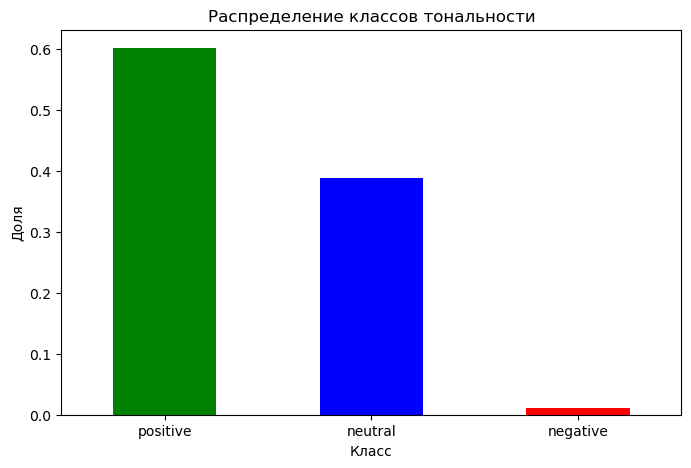

In [ ]:
# Проверка сбалансированности классов
class_distribution = df['sentiment_class'].value_counts(normalize=True)
print("Распределение классов:")
print(class_distribution)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Распределение классов тональности')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99,Rating,positive_words,negative_words,sentiment_class
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,-0.508544,0.493138,0.955332,-0.489594,0.762831,0.256382,0.9413,1.0,0.0,positive
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,...,-0.364489,0.214411,-0.124010,-1.199067,1.060075,0.564177,-0.1027,0.0,0.0,neutral
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...,...,0.130099,0.113614,-0.601902,-0.157523,0.612740,0.176813,0.8624,0.0,0.0,positive
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...,...,0.754666,0.631504,-0.142969,-0.207206,0.258513,1.571783,0.4404,1.0,0.0,neutral
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...,...,-0.525521,-0.350209,0.205153,-0.205225,0.797762,-0.048734,0.9468,2.0,0.0,positive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd

print("Подготовка данных")
features = ['char_length', 'word_count', 'Rating', 'positive_words', 'negative_words']
target = 'sentiment_class'

df_clean = df.dropna(subset=features + [target]).copy()
print(f"Исходный размер данных: {df.shape[0]} строк")
print(f"После очистки: {df_clean.shape[0]} строк (удалено {df.shape[0] - df_clean.shape[0]})")

class_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df_clean['sentiment_label'] = df_clean[target].map(class_mapping)

print("\nАнализ распределения классов")
X = df_clean[features].values
y = df_clean['sentiment_label'].values

class_counts = Counter(y)
print("\nРаспределение классов:")
for cls, count in class_counts.items():
    cls_name = [k for k, v in class_mapping.items() if v == cls][0]
    print(f"{cls_name} ({cls}): {count} примеров ({count / len(y):.1%})")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nРазмеры данных после разделения:")
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

print("\nБалансировка данных с помощью SMOTE (только train)")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nРаспределение классов после SMOTE:")
print(Counter(y_train_balanced))

balanced_df = pd.DataFrame(X_train_balanced, columns=features)
balanced_df['sentiment_label'] = y_train_balanced

reverse_mapping = {v: k for k, v in class_mapping.items()}
balanced_df['sentiment_class'] = balanced_df['sentiment_label'].map(reverse_mapping)

print("\nРезультат балансировки (train):")
print(balanced_df['sentiment_class'].value_counts(normalize=True))

balanced_df.to_csv('balanced_reviews_train.csv', index=False)
print("\nСбалансированные данные сохранены в balanced_reviews_train.csv")

test_df = pd.DataFrame(X_test, columns=features)
test_df['sentiment_label'] = y_test
test_df['sentiment_class'] = test_df['sentiment_label'].map(reverse_mapping)
test_df.to_csv('test_reviews.csv', index=False)
print("Тестовые данные сохранены в test_reviews.csv")

print("\nОбработка завершена успешно!")

Подготовка данных
Исходный размер данных: 568454 строк
После очистки: 568401 строк (удалено 53)

Анализ распределения классов

Распределение классов:
positive (2): 341682 примеров (60.1%)
neutral (1): 220870 примеров (38.9%)
negative (0): 5849 примеров (1.0%)

Размеры данных после разделения:
Train: 454720, Test: 113681

Балансировка данных с помощью SMOTE (только train)

Распределение классов после SMOTE:
Counter({1: 273345, 2: 273345, 0: 273345})

Результат балансировки (train):
sentiment_class
neutral     0.333333
positive    0.333333
negative    0.333333
Name: proportion, dtype: float64

Сбалансированные данные сохранены в balanced_reviews_train.csv
Тестовые данные сохранены в test_reviews.csv

Обработка завершена успешно!


Распределение классов:
sentiment_class
neutral     0.333333
positive    0.333333
negative    0.333333
Name: proportion, dtype: float64


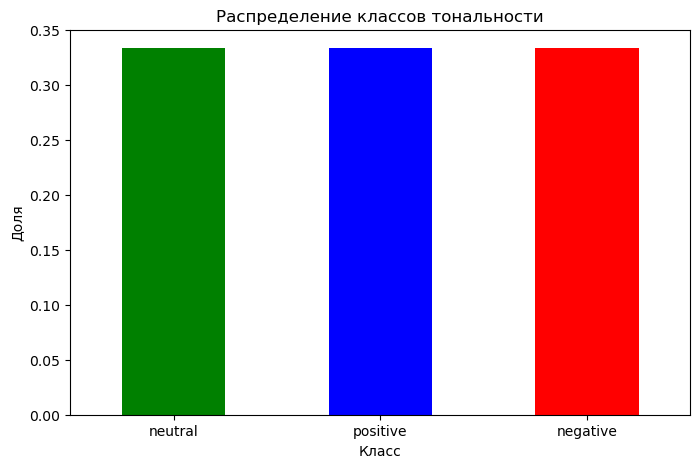

In [ ]:
# Проверка сбалансированности классов
class_distribution = balanced_df['sentiment_class'].value_counts(normalize=True)
print("Распределение классов:")
print(class_distribution)

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Распределение классов тональности')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.show()

Распределение классов:
sentiment_class
positive    0.601129
neutral     0.388579
negative    0.010292
Name: proportion, dtype: float64


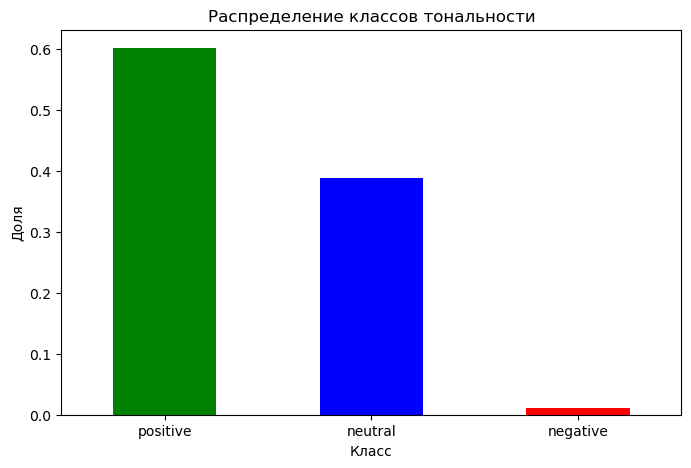

In [ ]:
# Проверка сбалансированности классов
class_distribution = test_df['sentiment_class'].value_counts(normalize=True)
print("Распределение классов:")
print(class_distribution)

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Распределение классов тональности')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.show()

In [ ]:
balanced_df.head()

,char_length,word_count,Rating,positive_words,negative_words,sentiment_label,sentiment_class
0,83.0,14.0,0.4767,0.0,0.0,1,neutral
1,107.0,16.0,0.8402,2.0,0.0,2,positive
2,752.0,123.0,0.9596,0.0,1.0,2,positive
3,70.0,9.0,0.3612,0.0,0.0,1,neutral
4,77.0,12.0,0.5859,0.0,0.0,1,neutral


теперь вместо одного DF два, balanced_df с данными для тренировки и test_df с данными для теста

5.Обучение моделей

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
import re
import logging

# Загрузка только необходимых ресурсов
nltk.download('wordnet')
nltk.download('omw-1.4')

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Упрощенная функция лемматизации без токенизации
def lemmatize_text(text):
    # Простое разбиение по пробелам (без punkt)
    words = text.split()
    # Базовая лемматизация
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmas)

# Обработка DataFrame
df['CleanText'] = df['CleanText'].apply(lemmatize_text)

# Разделение данных
X = df['CleanText']
y = df['sentiment_class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Логирование
logging.basicConfig(level=logging.INFO)
logging.info(f"Обработано записей: {len(df)}")
logging.info(f"Обучающая выборка: {len(X_train)}")
logging.info(f"Тестовая выборка: {len(X_test)}")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\balyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\balyb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


NameError: name 'df' is not defined

In [ ]:
import spacy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import logging

# Векторизация текста с помощью TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Обучение модели Logistic Regression
model_lr = LogisticRegression(class_weight='balanced', random_state=42)
model_lr.fit(X_train_tfidf, y_train)

# Прогнозирование на тестовой выборке
y_pred_lr = model_lr.predict(X_test_tfidf)

# Оценка модели
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average=None)  # F1-score по каждому классу
logging.info(f'Logistic Regression - Accuracy: {accuracy_lr:.4f}')
logging.info(f'Logistic Regression - F1-score: {f1_lr}')
logging.info(classification_report(y_test, y_pred_lr))

6.Интерпретация и визуализация

In [4]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем модель spacy для английского языка
nlp = spacy.load("en_core_web_sm")  # Замените на нужную модель для английского языка

# Функция для лемматизации текста
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Применяем лемматизацию к тексту
df['CleanText'] = df['CleanText'].apply(lemmatize_text)

# Определяем признаки и целевую переменную
X = df['CleanText']
y = df['sentiment_class']

# Векторизация текста с помощью TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# Обучение модели Logistic Regression
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_tfidf, y)

# Получение коэффициентов модели
coefficients = model.coef_
feature_names = tfidf.get_feature_names_out()  # Получаем имена признаков из TF-IDF

# Создание DataFrame для визуализации
coef_df = pd.DataFrame(coefficients, columns=feature_names)
coef_df = coef_df.transpose()
coef_df.columns = ['Coefficient']
coef_df['Word'] = coef_df.index

# Визуализация 10 самых важных слов для каждого класса
for i, sentiment in enumerate(model.classes_):
    top_words = coef_df.nlargest(10, 'Coefficient' if i == 0 else 'Coefficient').copy()
    top_words['Sentiment'] = sentiment
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Coefficient', y='Word', data=top_words)
    plt.title(f"10 самых важных слов для класса: {sentiment}")
    plt.xlabel("Коэффициент")
    plt.ylabel("Слово")
    plt.show()

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [1]:
import spacy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import shap
import logging

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")  # Use the appropriate language model

# Lemmatize with POS tagging for full coverage (nouns, verbs, adjectives, etc.)
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = []
    for token in doc:
        # Only keep alphanumeric tokens for features
        if token.is_alpha:
            # Use lemma, ensure verbs/adjectives are converted properly
            lemmas.append(token.lemma_)
    return " ".join(lemmas)

# Example DataFrame df with 'CleanText' and 'sentiment_class' columns must already be loaded
# Replace with your actual dataframe loading

# Apply full POS-aware lemmatization
df['CleanText'] = df['CleanText'].apply(lemmatize_text)

# Prepare features and target
X = df['CleanText']
y = df['sentiment_class']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Vectorize with TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train logistic regression model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_tfidf, y_train)

# Evaluate model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
logging.info(f"Accuracy: {accuracy:.4f}")
logging.info(f"F1-score: {f1}")
logging.info(classification_report(y_test, y_pred))

# SHAP analysis
explainer = shap.LinearExplainer(model, X_train_tfidf, feature_dependence="independent")
shap_values = explainer.shap_values(X_test_tfidf)

# Get feature names from vectorizer
feature_names = tfidf.get_feature_names_out()

# SHAP summary plot
shap.summary_plot(shap_values, X_test_tfidf, feature_names=feature_names)

ModuleNotFoundError: No module named 'shap'